In [1]:
import sys, os, importlib.util
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from scipy.constants import lambda2nu, nu2lambda, c
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [3]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

fdtdApi = lumapi.FDTD(hide = False)

In [4]:
um = 1e-6
nm = 1e-9

In [5]:
material_waveguide = 'Si (Silicon) - Palik'
material_background = 'SiO2 (Glass) - Palik'

In [113]:
n_c = 1.444
n_r = 3.476
lmbd = 1550*nm
W_m = 10*um
L = 176.5*um

In [7]:
altura = 220*nm
espessura = 480*nm
comprimento = 2*um

comprimento_taper = 6*um
espessura_taper = 2*um

espassamento = 0.5*um

espessura_sub = 25*um
altura_sub = 2*um
comprimento_sub = (L + comprimento_taper*2 + comprimento*2) + 10*um

In [8]:
start_wavelength = 1530*nm
stop_wavelength = 1570*nm
num_frequency_points = 25

mesh_accuracy = 2

time_simulation = (L + 2*comprimento_taper + 2*comprimento)*7/c + 200e-15

In [9]:
x_MMI = 0
y_MMI = 0
z_MMI = 0

x_substract = 0
y_substract = 0
z_substract = -altura/2- altura_sub/2

x_taper = L/2 + comprimento_taper/2
y_taper = (espassamento + espessura_taper)/2
z_taper = z_MMI

x_waveguide =  L/2 + comprimento_taper + comprimento/2
y_waveguide = y_taper
z_waveguide = z_taper

x_solver_span = L + comprimento_taper*2 + comprimento*2
y_solver_span = W_m*2
z_solver_span = altura*10

port_span = 2*um

In [10]:
fdtdApi.switchtolayout()

fdtdApi.select('GDS_LAYER_35:4')
fdtdApi.delete()

fdtdApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
fdtdApi.set('name', dev_layer)
fdtdApi.set('x', x_MMI)
fdtdApi.set('y', y_MMI)

In [11]:
fdtdApi.switchtolayout()

fdtdApi.select(f'{dev_layer}::Substract')
fdtdApi.delete()

fdtdApi.addrect()
fdtdApi.addtogroup(dev_layer)
fdtdApi.set('name', 'Substract')
fdtdApi.set('x span', comprimento_sub)
fdtdApi.set('y span', espessura_sub)
fdtdApi.set('z span', altura_sub)
fdtdApi.set('x', x_substract)
fdtdApi.set('y', y_substract)
fdtdApi.set('z', z_substract)
fdtdApi.set('material', material_background)

fdtdApi.select(f'{dev_layer}::Box')
fdtdApi.delete()

fdtdApi.addrect()
fdtdApi.addtogroup(dev_layer)
fdtdApi.set('name', 'Box')
fdtdApi.set('x span', L)
fdtdApi.set('y span', W_m)
fdtdApi.set('z span', altura)
fdtdApi.set('x', x_MMI)
fdtdApi.set('y', y_MMI)
fdtdApi.set('z', z_MMI)
fdtdApi.set('material', material_waveguide)

In [12]:
fdtdApi.switchtolayout()

for i in range(1,9):
    taper_name = f'Taper_{i}'
    fdtdApi.select(taper_name)
    fdtdApi.delete()
    fdtdApi.addobject('linear_taper')
    fdtdApi.addtogroup(dev_layer)
    fdtdApi.set('name', taper_name)
    fdtdApi.set('angle_side', 90)
    fdtdApi.set('thickness', altura)
    fdtdApi.set("len", comprimento_taper)
    fdtdApi.set("material", material_waveguide)
    fdtdApi.set("z", z_taper)
    if i<=4:
        fdtdApi.set("width_l", espessura)
        fdtdApi.set("width_r", espessura_taper)
        fdtdApi.set('x', -x_taper)
        if i==1 or i==4:
            fdtdApi.set('y', -(-1)**i*y_taper*3)
        else:
            fdtdApi.set('y', (-1)**i*y_taper)
    else:
        fdtdApi.set("width_l", espessura_taper)
        fdtdApi.set("width_r", espessura)
        fdtdApi.set('x', x_taper)
        if i==5 or i==8:
            fdtdApi.set('y', -(-1)**i*y_taper*3)
        else:
            fdtdApi.set('y', (-1)**i*y_taper)

In [13]:
fdtdApi.switchtolayout()

for i in range(1,9):
    waveguide_name = f'Waveguide_{i}'
    fdtdApi.select(waveguide_name)
    fdtdApi.delete()
    fdtdApi.addrect()
    fdtdApi.addtogroup(dev_layer)
    fdtdApi.set('name', waveguide_name)
    fdtdApi.set('x span', comprimento)
    fdtdApi.set('y span', espessura)
    fdtdApi.set('z span', altura)
    fdtdApi.set('z', z_waveguide)
    fdtdApi.set('material', material_waveguide)
    if i<=4:
        fdtdApi.set('x', -x_waveguide)
        if i==1 or i==4:
            fdtdApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            fdtdApi.set('y', (-1)**i*y_waveguide)
    else:
        fdtdApi.set('x', x_waveguide)
        if i==5 or i==8:
            fdtdApi.set('y', -(-1)**i*y_waveguide*3)
        else:
            fdtdApi.set('y', (-1)**i*y_waveguide)

In [14]:
fdtdApi.switchtolayout()

fdtdApi.select('FDTD')
fdtdApi.delete()

fdtdApi.addfdtd()
fdtdApi.set('background material', material_background)

fdtdApi.set('x', x_MMI)
fdtdApi.set('y', y_MMI)
fdtdApi.set('z', z_MMI)
fdtdApi.set('x span', x_solver_span)
fdtdApi.set('y span', y_solver_span)
fdtdApi.set('z span', z_solver_span)

fdtdApi.set('mesh accuracy', mesh_accuracy)
fdtdApi.set('simulation time', time_simulation)

fdtdApi.set('x min bc', 'PML')
fdtdApi.set('x max bc', 'PML')
fdtdApi.set('y min bc', 'PML')
fdtdApi.set('y max bc', 'PML')
fdtdApi.set('z min bc', 'PML')
fdtdApi.set('z max bc', 'PML')

fdtdApi.set('global source wavelength start', start_wavelength)
fdtdApi.set('global source wavelength stop', stop_wavelength)

In [15]:
fdtdApi.switchtolayout()

for i in range(1,9):
    port_name = f'FDTD::Ports::port_{i}'
    fdtdApi.select(port_name)
    fdtdApi.delete()
    fdtdApi.addport()
    fdtdApi.set('name',port_name)
    fdtdApi.set('injection axis', 'x-axis')

    fdtdApi.set("z", 0)
    fdtdApi.set('y span', port_span)
    fdtdApi.set('z span', port_span)
    fdtdApi.set("mode selection", "fundamental TE mode")
    if i<=4:
        fdtdApi.set('x', -(L/2 + comprimento_taper))
        fdtdApi.set('direction', 'Forward')
        if 2<=i<=3:
            fdtdApi.set("y", ((-1)**i)*y_taper)
        else:
            fdtdApi.set("y", (-(-1)**i)*y_taper*3)
    else:
        fdtdApi.set('x', (L/2 + comprimento_taper))
        fdtdApi.set('direction', 'Backward')
        if 6<=i<=7:
            fdtdApi.set("y", ((-1)**i)*y_taper)
        else:
            fdtdApi.set("y", (-(-1)**i)*y_taper*3)

fdtdApi.select('FDTD::ports')
fdtdApi.set('monitor frequency points', num_frequency_points)

In [16]:
fdtdApi.switchtolayout()

fdtdApi.select('Monitor_E')
fdtdApi.delete()

fdtdApi.addprofile()
fdtdApi.set('name', 'Monitor_E')
fdtdApi.set('override global monitor settings', True)
fdtdApi.set('frequency points', num_frequency_points)
fdtdApi.set('x', x_MMI)
fdtdApi.set('y', y_MMI)
fdtdApi.set('z', z_MMI)
fdtdApi.set("x span", x_solver_span)
fdtdApi.set("y span", y_solver_span)

In [17]:
filename = 'FSimulacao MMI - FDTD'
fdtdApi.save(filename)

In [18]:
fdtdApi.run(3)

In [83]:
E = fdtdApi.getresult('Monitor_E', 'E')

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um

z = E['z']
E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + Ez**2)
Emag_log = 10*np.log10((Emag[:,:,0]))

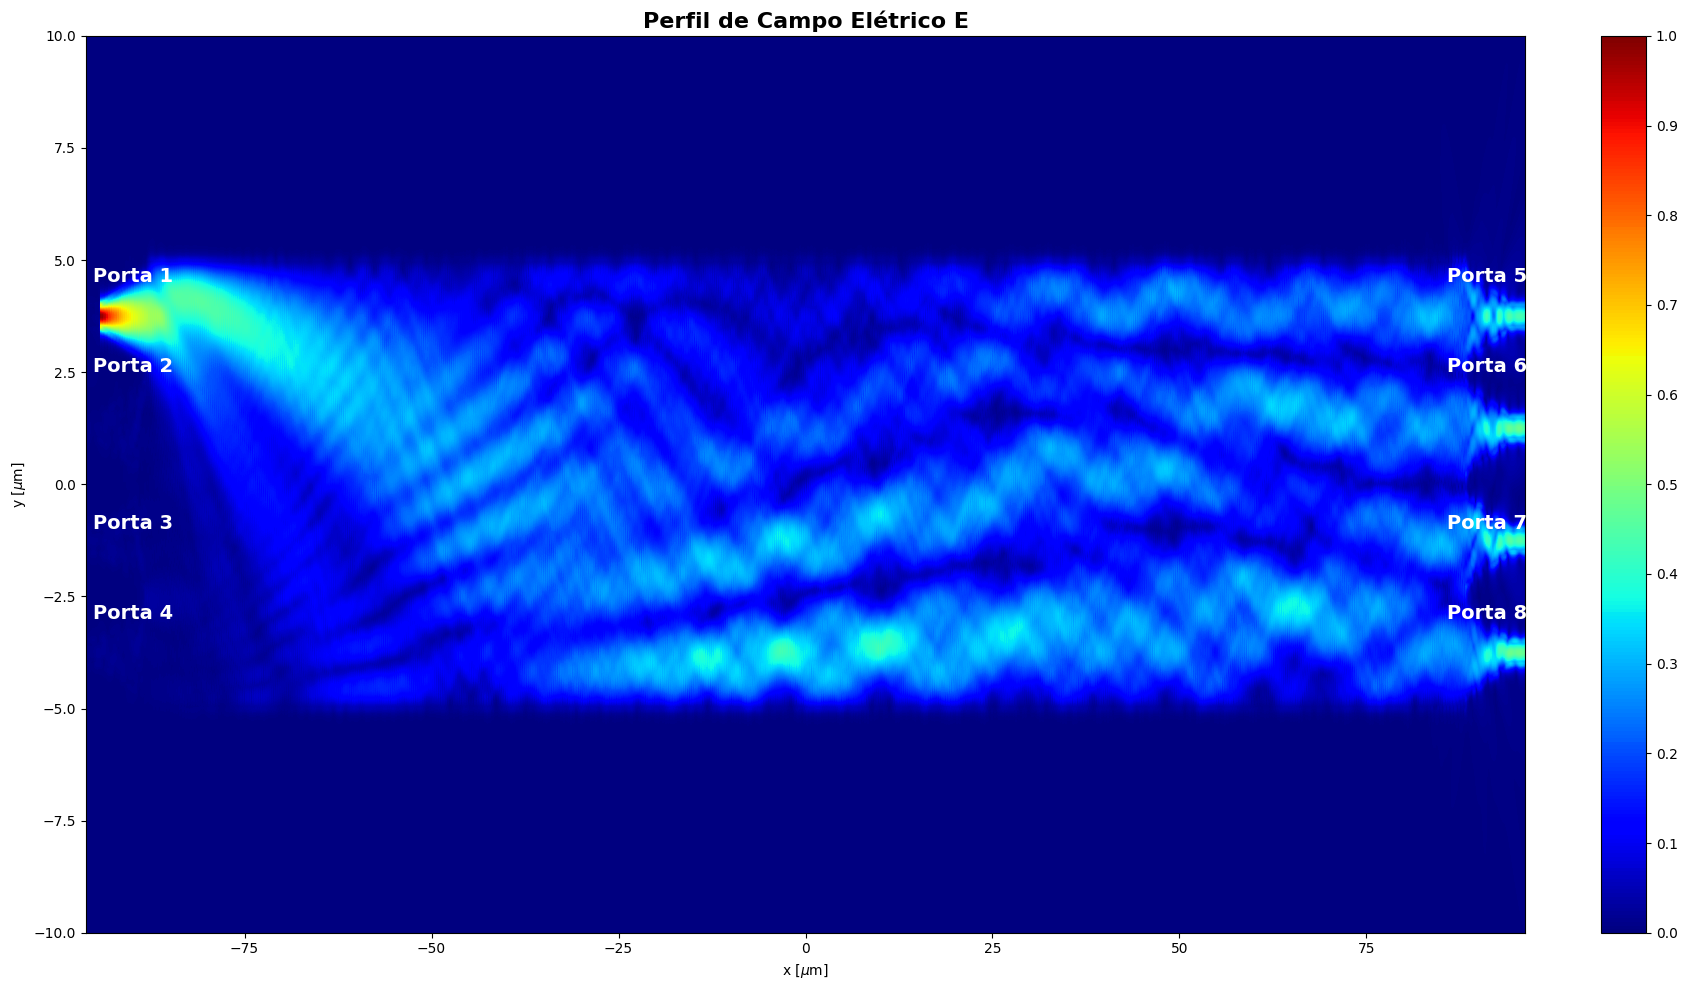

In [141]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(Emag.min(),1.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag[:,:,0]), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(0,1,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title('Perfil de Campo Elétrico E', fontsize = 16, fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Eletrico_Linear_FDTD.png')
plt.show()

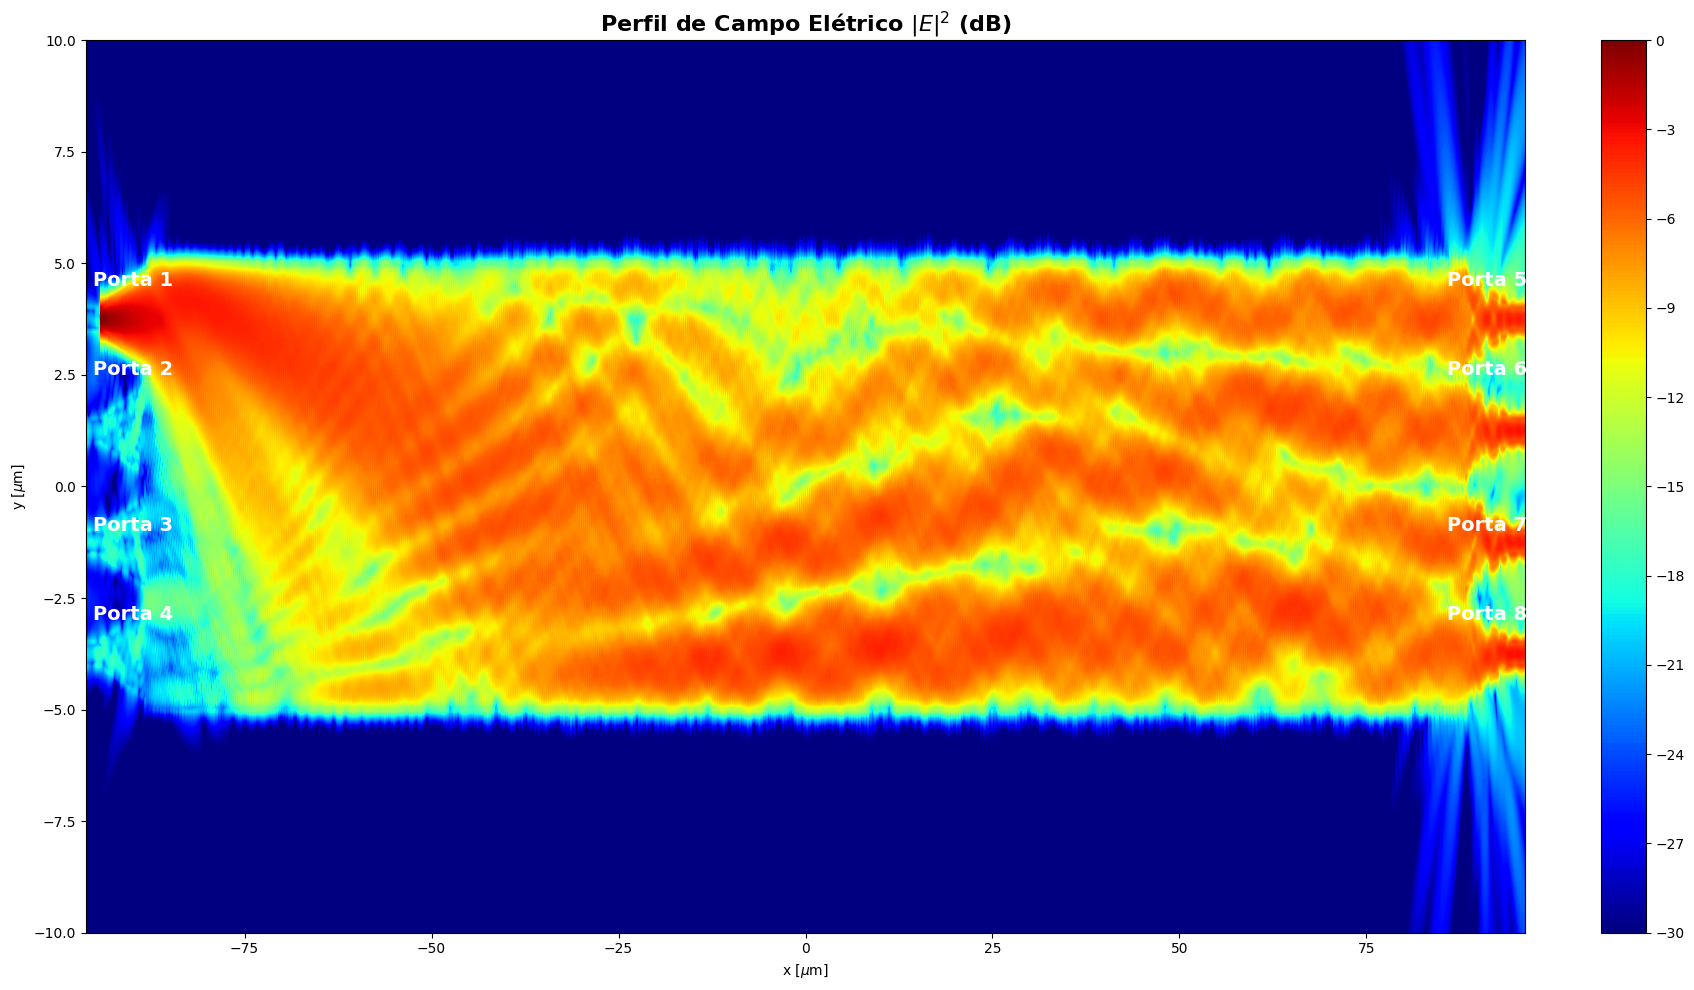

In [142]:
plt.figure(figsize=(20, 10))
mycmap = plt.get_cmap('jet')

v = np.linspace(-30,0.00001,250,endpoint=True)

plt.contourf(x,y,np.clip(np.transpose(Emag_log), v.min(), v.max()),v,cmap = mycmap)
plt.colorbar(ticks=np.linspace(-30,0,11, endpoint=True), fraction=0.2, pad=0.04)

plt.title(r'Perfil de Campo Elétrico $|E|^2$ (dB)', fontsize = 16,  fontweight = 'bold',)
plt.ylabel(r'y [$\mu$m]')
plt.xlabel(r'x [$\mu$m]')

plt.text(-x_waveguide/um, 4.5, 'Porta 1', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, 2.5, 'Porta 2', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -1, 'Porta 3', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(-x_waveguide/um, -3, 'Porta 4', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 4.5, 'Porta 5', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, 2.5, 'Porta 6', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -1, 'Porta 7', fontsize = 14, fontweight = 'bold', color = 'w')
plt.text(x_waveguide/um - 9.5, -3, 'Porta 8', fontsize = 14, fontweight = 'bold', color = 'w')

plt.tight_layout()
plt.savefig('Perfil_de_Campo_Eletrico_LOG_FDTD.png')
plt.show()

In [22]:
trans_1 = np.abs(fdtdApi.getresult('FDTD::ports::port_1', 'T')['T'])
trans_2 = np.abs(fdtdApi.getresult('FDTD::ports::port_2', 'T')['T'])
trans_3 = np.abs(fdtdApi.getresult('FDTD::ports::port_3', 'T')['T'])
trans_4 = np.abs(fdtdApi.getresult('FDTD::ports::port_4', 'T')['T'])
trans_5 = np.abs(fdtdApi.getresult('FDTD::ports::port_5', 'T')['T'])
trans_6 = np.abs(fdtdApi.getresult('FDTD::ports::port_6', 'T')['T'])
trans_7 = np.abs(fdtdApi.getresult('FDTD::ports::port_7', 'T')['T'])
trans_8 = np.abs(fdtdApi.getresult('FDTD::ports::port_8', 'T')['T'])

trans_1_dB = 10*np.log10(trans_1)
trans_2_dB = 10*np.log10(trans_2)
trans_3_dB = 10*np.log10(trans_3)
trans_4_dB = 10*np.log10(trans_4)
trans_5_dB = 10*np.log10(trans_5)
trans_6_dB = 10*np.log10(trans_6)
trans_7_dB = 10*np.log10(trans_7)
trans_8_dB = 10*np.log10(trans_8)

Lambda = fdtdApi.getresult('FDTD::ports::port_1', 'T')['lambda']/nm

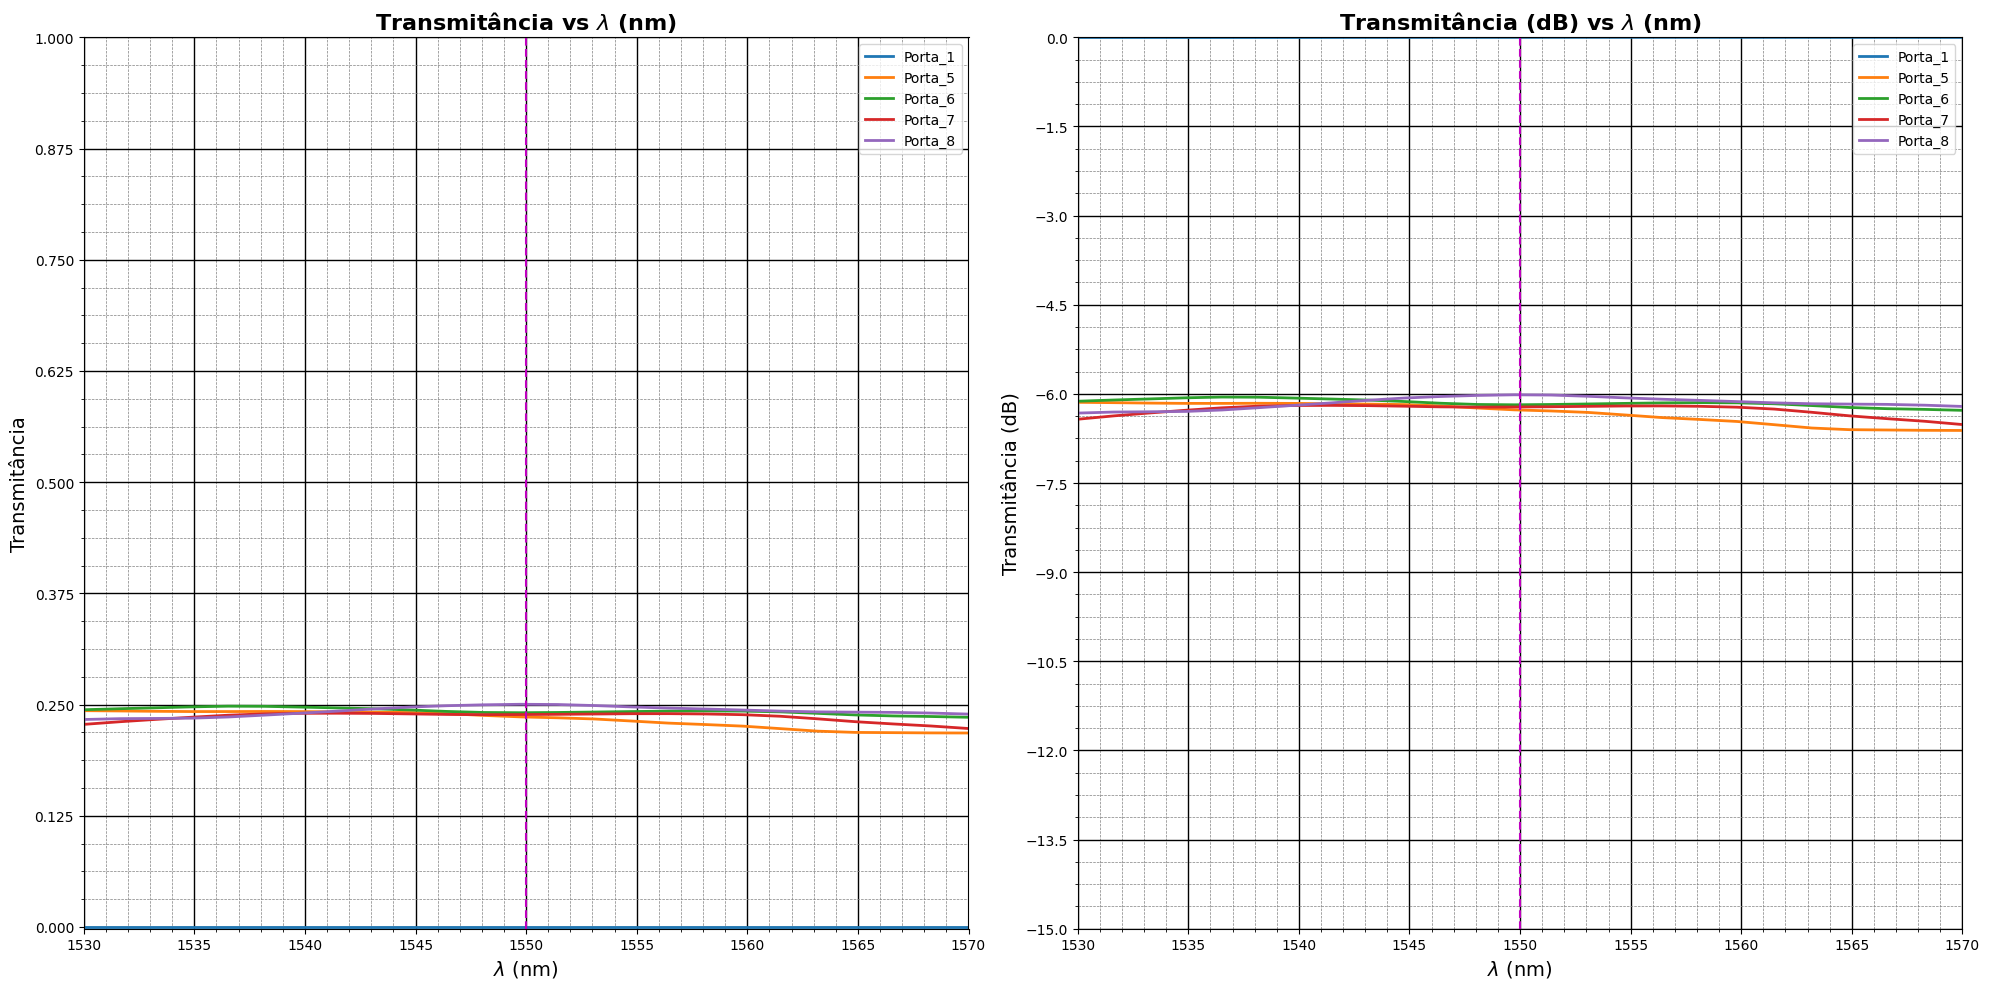

In [139]:
valor_lambda = 1550

fig3, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(Lambda, trans_1 - trans_1, label = 'Porta_1', linewidth=2)
axs[0].plot(Lambda, trans_5, label = 'Porta_5', linewidth=2)
axs[0].plot(Lambda, trans_6, label = 'Porta_6', linewidth=2)
axs[0].plot(Lambda, trans_7, label = 'Porta_7', linewidth=2)
axs[0].plot(Lambda, trans_8, label = 'Porta_8', linewidth=2)
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Transmitância', fontsize=14)
axs[0].set_title(r'Transmitância vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].legend()
axs[0].set_xlim([1530, 1570])
axs[0].set_ylim([-0.002, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.125))
axs[0].axvline(x=lmbd/nm, color='m', linestyle='--')

axs[1].plot(Lambda, trans_1_dB, label = 'Porta_1', linewidth=2)
axs[1].plot(Lambda, trans_5_dB, label = 'Porta_5', linewidth=2)
axs[1].plot(Lambda, trans_6_dB, label = 'Porta_6', linewidth=2)
axs[1].plot(Lambda, trans_7_dB, label = 'Porta_7', linewidth=2)
axs[1].plot(Lambda, trans_8_dB, label = 'Porta_8', linewidth=2)
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Transmitância (dB)', fontsize=14)
axs[1].set_title(r'Transmitância (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold',)
axs[1].set_ylim([-15, 0])
axs[1].set_xlim([1530, 1570])
axs[1].set_yticks(np.arange(-15, 0.1, 1.5))
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].legend()
axs[1].axvline(x=lmbd/nm, color='m', linestyle='--')

plt.tight_layout()
plt.savefig('Transmissao_nas_portas_FDTD.png')
plt.show()

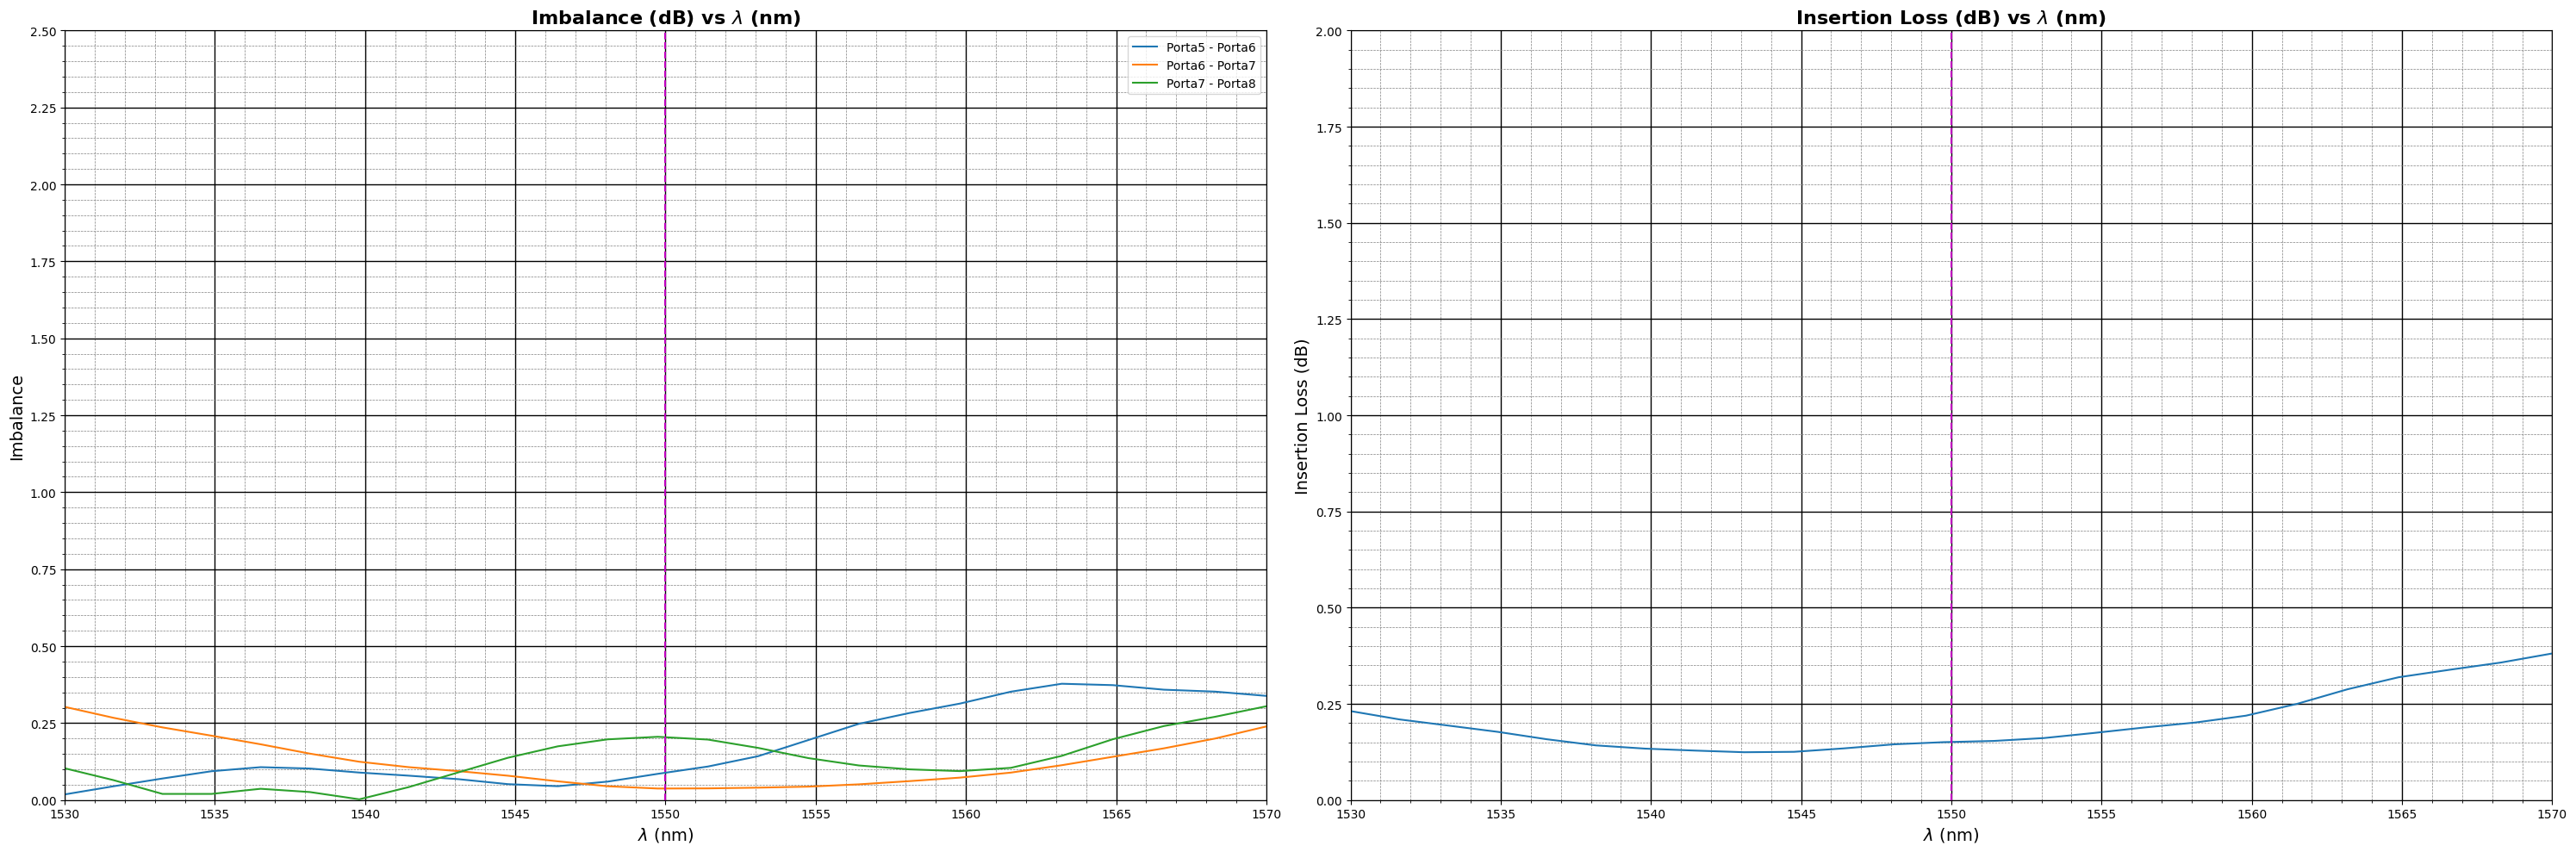

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

Ib1 = np.abs(trans_5_dB - trans_6_dB)
Ib2 = np.abs(trans_6_dB - trans_7_dB)
Ib3 = np.abs(trans_7_dB - trans_8_dB)
axs[0].plot(Lambda, Ib1, lw=1.5, label='Porta5 - Porta6')
axs[0].plot(Lambda, Ib2, lw=1.5, label='Porta6 - Porta7')
axs[0].plot(Lambda, Ib3, lw=1.5, label='Porta7 - Porta8')
axs[0].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[0].set_ylabel('Imbalance', fontsize=14)
axs[0].set_title(r'Imbalance (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[0].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[0].minorticks_on()
axs[0].axvline(x=valor_lambda, color='m', linestyle='--')
axs[0].set_xlim([1530,1570])
axs[0].set_ylim([0,2.5])
axs[0].set_yticks(np.arange(0, 2.6, 0.25))
axs[0].set_xlim([start_wavelength/nm, stop_wavelength/nm])
axs[0].legend()

Il = -10*np.log10(trans_5 + trans_6 + trans_7 + trans_8)
axs[1].plot(Lambda, Il, lw=1.5)
axs[1].set_xlabel(r'$\lambda$ (nm)', fontsize=14)
axs[1].set_ylabel('Insertion Loss (dB)', fontsize=14)
axs[1].set_title(r'Insertion Loss (dB) vs $\lambda$ (nm)', fontsize=16, fontweight = 'bold')
axs[1].grid(True, which='major', linestyle='-', linewidth=1, color='black')
axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray')
axs[1].minorticks_on()
axs[1].axvline(x=valor_lambda, color='m', linestyle='--')
axs[1].set_xlim([start_wavelength/nm, stop_wavelength/nm])
axs[1].set_xlim([1530,1570])
axs[1].set_ylim([0,2])
axs[1].set_yticks(np.arange(0, 2.1, 0.25))

plt.tight_layout()
plt.savefig('Imbalance_e_Perda_de_Insercao_nas_portas_FDTD.png')
plt.show()

In [25]:
file_path = r"G:\Outros computadores\Meu laptop - Pessoal\Engenharia Eletrica\Projeto\Adolfo\Projeto final\INTERCONNECT\Interconect_Signal_Noramlized_FDTD.txt"

porta_5_data = []
porta_6_data = []
porta_7_data = []
porta_8_data = []

current_port = None

with open(file_path, 'r') as file:
    for line in file:
        if 'Porta5' in line:
            current_port = 'Porta5'
            continue
        elif 'Porta6' in line:
            current_port = 'Porta6'
            continue
        elif 'Porta7' in line:
            current_port = 'Porta7'
            continue
        elif 'Porta8' in line:
            current_port = 'Porta8'
            continue

        try:
            wavelength, signal = map(float, line.strip().split(','))
            if current_port == 'Porta5':
                porta_5_data.append((wavelength, signal))
            elif current_port == 'Porta6':
                porta_6_data.append((wavelength, signal))
            elif current_port == 'Porta7':
                porta_7_data.append((wavelength, signal))
            elif current_port == 'Porta8':
                porta_8_data.append((wavelength, signal))
        except ValueError:
            continue


signal_5 = pd.DataFrame(porta_5_data, columns=['wavelength', 'signal'])
signal_6 = pd.DataFrame(porta_6_data, columns=['wavelength', 'signal'])
signal_7 = pd.DataFrame(porta_7_data, columns=['wavelength', 'signal'])
signal_8 = pd.DataFrame(porta_8_data, columns=['wavelength', 'signal'])

Lambda = signal_5['wavelength']

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Outros computadores\\Meu laptop - Pessoal\\Engenharia Eletrica\\Projeto\\Adolfo\\Projeto final\\INTERCONNECT\\Interconect_Signal_Noramlized_FDTD.txt'

In [ ]:
valor_lambda = 1550

plt.figure(figsize=(20, 10))

plt.plot(Lambda, signal_5['signal'], label='Porta_5', linewidth=1)
plt.plot(Lambda, signal_6['signal'], label='Porta_6', linewidth=1)
plt.plot(Lambda, signal_7['signal'], label='Porta_7', linewidth=1)
plt.plot(Lambda, signal_8['signal'], label='Porta_8', linewidth=1)
plt.axvline(x=valor_lambda, color='m', linestyle='--')
plt.xlabel(r'wavelength [nm]', fontsize=14)
plt.ylabel('Gain Signal(dB)', fontsize=14)
plt.title(r'GainSignal (dB) vs $\lambda$ ($\mu$m)', fontsize=16, fontweight = 'bold',)
plt.legend()
plt.xlim([1547.5, 1552.5])
plt.grid(which='major', color='black', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='--')
plt.minorticks_on()

In [ ]:
file_path = r"G:\Outros computadores\Meu laptop - Pessoal\Engenharia Eletrica\Projeto\Adolfo\Projeto final\INTERCONNECT\Interconect_FSR_FDTD.txt"

porta_5_data = []
porta_6_data = []
porta_7_data = []
porta_8_data = []

current_port = None

with open(file_path, 'r') as file:
    for line in file:
        if 'Porta5' in line:
            current_port = 'Porta5'
            continue
        elif 'Porta6' in line:
            current_port = 'Porta6'
            continue
        elif 'Porta7' in line:
            current_port = 'Porta7'
            continue
        elif 'Porta8' in line:
            current_port = 'Porta8'
            continue

        try:
            wavelength, phase = map(float, line.strip().split(','))
            if current_port == 'Porta5':
                porta_5_data.append((wavelength, phase))
            elif current_port == 'Porta6':
                porta_6_data.append((wavelength, phase))
            elif current_port == 'Porta7':
                porta_7_data.append((wavelength, phase))
            elif current_port == 'Porta8':
                porta_8_data.append((wavelength, phase))
        except ValueError:
            continue

d_lmbd = 0.275*nm

print(f'A diferença de comprmento de onda entre os vales de uma porta para outra para garantir \u0394\u03C6 = 90° é \u0394\u03BB = {d_lmbd/nm:.3f}nm')

phase_5 = pd.DataFrame(porta_5_data, columns=['wavelength', 'phase'])
phase_6 = pd.DataFrame(porta_6_data, columns=['wavelength', 'phase'])
phase_7 = pd.DataFrame(porta_7_data, columns=['wavelength', 'phase'])
phase_8 = pd.DataFrame(porta_8_data, columns=['wavelength', 'phase'])

d_phase5 = 0*((2*np.pi*d_lmbd)/phase_5['phase'])*(180/np.pi)
d_phase6 = 1*((2*np.pi*d_lmbd)/phase_6['phase'])*(180/np.pi)
d_phase7 = 2*((2*np.pi*d_lmbd)/phase_7['phase'])*(180/np.pi)
d_phase8 = 3*((2*np.pi*d_lmbd)/phase_8['phase'])*(180/np.pi)

In [ ]:
valor_lambda = 1550
plt.figure(figsize=(20, 10))

plt.plot(phase_5['wavelength'], d_phase5, label=r'$\Delta\Phi$(Porta_5)', linewidth=1)
plt.plot(phase_6['wavelength'], d_phase6, label=r'$\Delta\Phi$(Porta_6)', linewidth=1)
plt.plot(phase_7['wavelength'], d_phase7, label=r'$\Delta\Phi$(Porta_7)', linewidth=1)
plt.plot(phase_8['wavelength'], d_phase8, label=r'$\Delta\Phi$(Porta_8)', linewidth=1)
plt.axvline(x=valor_lambda, color='m', linestyle='--')
plt.xlabel(r'wavelength [nm]', fontsize=14)
plt.ylabel('Diferança de Fase(°)', fontsize=14)
plt.title(r'Diferança de Fase(°) vs $\lambda$ ($\mu$m)', fontsize=16, fontweight = 'bold',)
plt.legend()
plt.grid(which='major', color='black', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='--')
plt.minorticks_on()